In [143]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, normalize
from timeit import default_timer as timer
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import itertools

def load_data(filename):
    df = pd.read_csv("./data/" + filename)
    print("Original dataset shape is: {}".format(df.shape))
    if filename == "falldeteciton.csv":   
        X = df.iloc[:,1:]
        y = df.iloc[:,0] 
        print(sorted(df['ACTIVITY'].unique()))
    else:
        X = df.iloc[:,:-1]
        y = df.iloc[:,-1]
        print(sorted(df['target_class'].unique()))
    return X, y

def split_data(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=test_size)
    return X_train, X_test, y_train, y_test

def normalize_data(X_train, X_test):
    sc = StandardScaler()
    X_train_scale = sc.fit_transform(X_train)
    X_test_scale = sc.transform(X_test)
    return X_train_scale, X_test_scale

#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
    
def cluster_predictions(y, cluster_labels):
    assert (y.shape == cluster_labels.shape)
    pred = np.empty_like(y)
    for label in set(cluster_labels):
        mask = cluster_labels == label
        sub = y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target   
    return pred

## Part 1: Clustering Algorithms 

In [144]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score as sil_score, f1_score
from sklearn.metrics.cluster import completeness_score, homogeneity_score, v_measure_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

def kmeans_cluster(X,y,title):
    k_range = range(2, 16)
    scores = []; sil_scores = []; f1_scores = []; train_times = []

    for k in k_range:
        start = timer()
        km = KMeans(n_clusters=k,init='random',n_init=10).fit(X)
        end = timer()
        train_times.append(end - start)
        score = km.inertia_
        scores.append(score)   
        sil_scores.append(sil_score(X, km.labels_))
        y_mode_vote = cluster_predictions(y, km.labels_)
        f1_scores.append(f1_score(y, y_mode_vote, average='weighted'))
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, scores, "-o")
    plt.grid(True)
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE Score')
    plt.title('SSE vs Clusters - KMeans: '+ title)
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, sil_scores, "-o")
    plt.grid(True)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Mean Silhouette Score')
    plt.title('Silhouette vs Clusters - KMeans: '+ title)
    plt.show()
   
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, f1_scores, "-o")
    plt.grid(True)
    plt.xlabel('Number of Clusters')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores vs Clusters - KMeans: '+ title)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, train_times, "-o")
    plt.grid(True)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Seconds')
    plt.title('KMeans Training Time: '+ title)
    plt.show()
    
def em_cluster(X,y,title):
    k_range = range(2, 16)
    aic_scores = []; bic_scores = []; sil_scores = []; f1_scores = []; train_times = []

    for k in k_range:
        start = timer()
        em = GaussianMixture(n_components=k,init_params='random',n_init=10,random_state=10).fit(X)
        end = timer()
        train_times.append(end - start)
        aic_score = em.aic(X)
        bic_score = em.bic(X)
        aic_scores.append(aic_score) 
        bic_scores.append(bic_score)
        labels = em.predict(X)
        sil_scores.append(sil_score(X, labels))
        y_mode_vote = cluster_predictions(y, labels)
        f1_scores.append(f1_score(y, y_mode_vote, average='weighted'))
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, aic_scores, label='AIC')
    ax.plot(k_range, bic_scores,label='BIC')
    plt.grid(True)
    plt.xlabel('Number of Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('EM Model Complexity: '+ title)
    plt.legend(loc="best")
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, sil_scores, "-o")
    plt.grid(True)
    plt.xlabel('Number of Distributions')
    plt.ylabel('Mean Silhouette Score')
    plt.title('Silhouette vs Distributions - EM: '+ title)
    plt.show()
   
    # plot f1 scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, f1_scores, "-o")
    plt.grid(True)
    plt.xlabel('Number of Distributions')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores vs Distributions - EM: '+ title)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k_range, train_times, "-o")
    plt.grid(True)
    plt.xlabel('Number of Distributions')
    plt.ylabel('Seconds')
    plt.title('EM Training Time: '+ title)
    plt.show()
    
def kmeans_evaluate(X, y, n_comp, title):
    km = KMeans(n_clusters=n_comp, init='random', n_init=10)
    start = timer()
    km.fit(X, y)
    end = timer()
    train_time = end - start
    print("*****************************************************")
    print("Dataset: {}".format(title))
    print("Number of Components: {}".format(n_comp))
    print("Homogeneity: {0:.3f}".format(homogeneity_score(y, km.labels_)))
    print("Completeness: {0:.3f}".format(completeness_score(y, km.labels_)))
    print("V-measure: {0:.3f}".format(v_measure_score(y, km.labels_)))
    
    y_mode_vote = cluster_predictions(y, km.labels_)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote, average="weighted")

    print("****** Model Evaluation Metrics Using Mode Cluster Vote ******")
    print("Model Training Time:   "+"{:.2f}".format(train_time))
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    print("Precision: "+"{:.2f}".format(precision))
    print("*****************************************************")
    
def em_evaluate(X, y, n_comp, title):
    em = GaussianMixture(n_components=n_comp,init_params='random',n_init=10,random_state=10)
    start = timer()
    em.fit(X, y)
    end = timer()
    train_time = end - start
    labels = em.predict(X)
    print("*****************************************************")
    print("Dataset: {}".format(title))
    print("Number of Distributions: {}".format(n_comp))
    print("Homogeneity: {0:.3f}".format(homogeneity_score(y, labels)))
    print("Completeness: {0:.3f}".format(completeness_score(y, labels)))
    print("V-measure: {0:.3f}".format(v_measure_score(y, labels)))
    
    y_mode_vote = cluster_predictions(y, labels)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote, average="weighted")

    print("****** Model Evaluation Metrics Using Mode Cluster Vote ******")
    print("Model Training Time:   "+"{:.2f}".format(train_time))
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    print("Precision: "+"{:.2f}".format(precision))
    print("*****************************************************")

Original dataset shape is: (17898, 9)
[0, 1]


/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


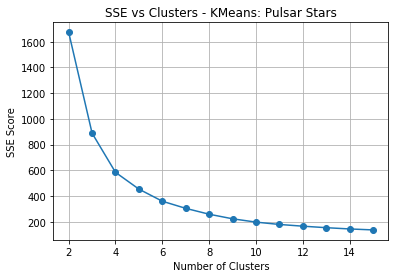

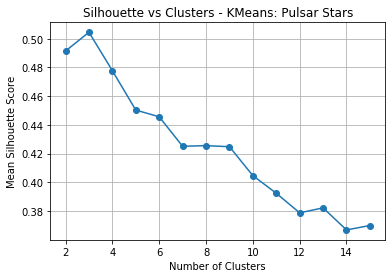

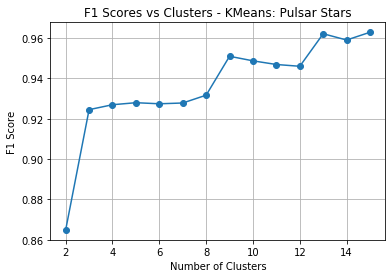

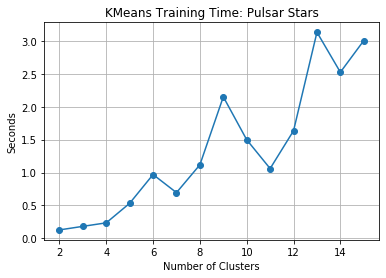

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


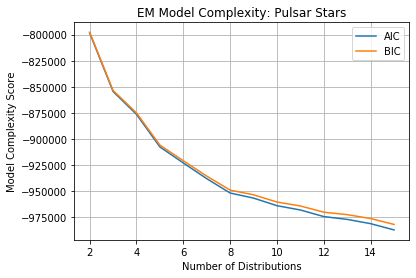

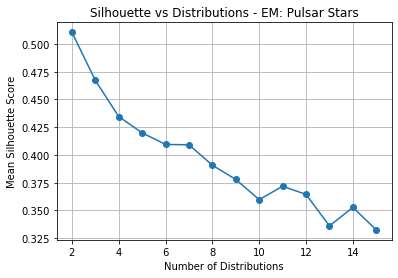

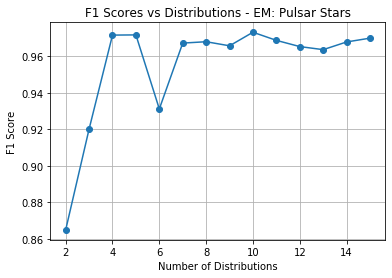

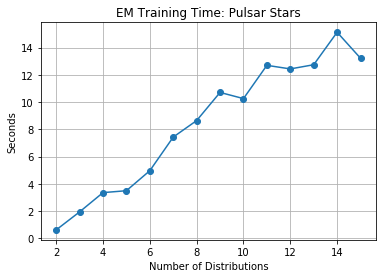

Original dataset shape is: (16382, 7)
[0, 1, 2, 3, 4, 5]


/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

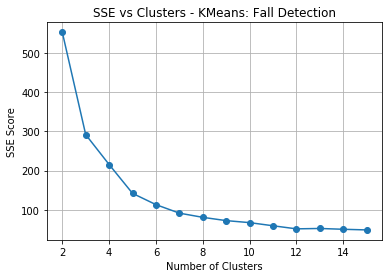

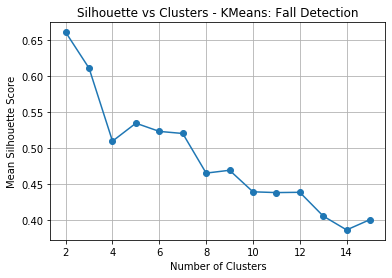

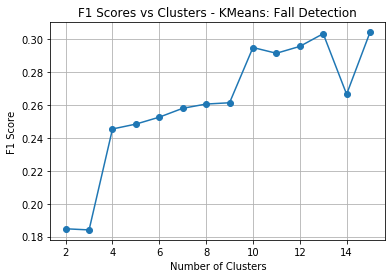

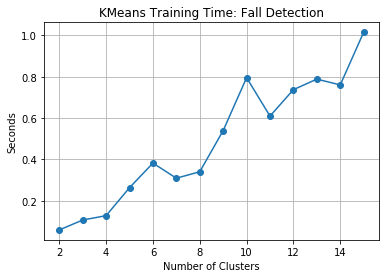

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

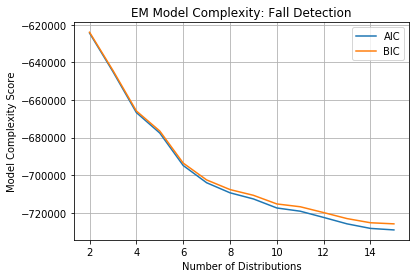

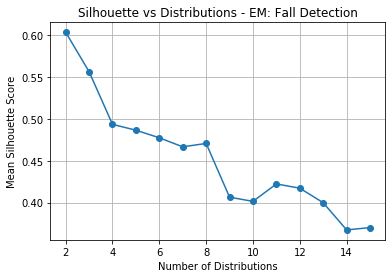

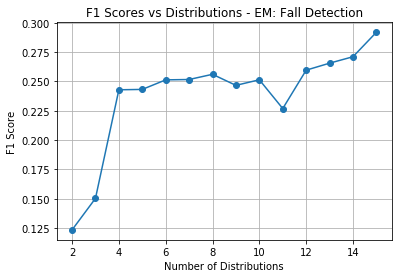

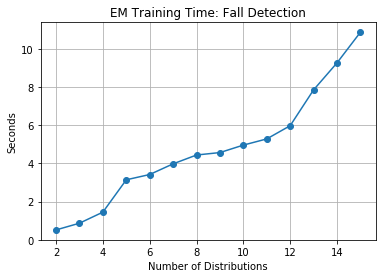

In [145]:
filename1 = "pulsar_stars.csv"
filename2 = "falldeteciton.csv"
X_pulsar, y_pulsar = load_data(filename1)
X_pulsar = normalize(X_pulsar)
kmeans_cluster(X_pulsar,y_pulsar,'Pulsar Stars')
em_cluster(X_pulsar,y_pulsar,'Pulsar Stars')

X_fall, y_fall = load_data(filename2)
X_fall = normalize(X_fall)
kmeans_cluster(X_fall,y_fall,'Fall Detection')
em_cluster(X_fall,y_fall,'Fall Detection')

In [146]:
kmeans_evaluate(X_pulsar,y_pulsar,3,'Pulsar Stars')
kmeans_evaluate(X_pulsar,y_pulsar,4,'Pulsar Stars')

em_evaluate(X_pulsar,y_pulsar,4,'Pulsar Stars')
em_evaluate(X_pulsar,y_pulsar,5,'Pulsar Stars')

kmeans_evaluate(X_fall,y_fall,3,'Fall Detection')
kmeans_evaluate(X_fall,y_fall,5,'Fall Detection')

em_evaluate(X_fall,y_fall,4,'Fall Detection')
em_evaluate(X_fall,y_fall,6,'Fall Detection')

*****************************************************
Dataset: Pulsar Stars
Number of Components: 3
Homogeneity: 0.366
Completeness: 0.115
V-measure: 0.175
****** Model Evaluation Metrics Using Mode Cluster Vote ******
Model Training Time:   0.17
Accuracy:  0.92
Precision: 0.93
*****************************************************
*****************************************************
Dataset: Pulsar Stars
Number of Components: 4
Homogeneity: 0.366
Completeness: 0.086
V-measure: 0.140
****** Model Evaluation Metrics Using Mode Cluster Vote ******
Model Training Time:   0.28
Accuracy:  0.93
Precision: 0.93
*****************************************************
*****************************************************
Dataset: Pulsar Stars
Number of Distributions: 4
Homogeneity: 0.640
Completeness: 0.166
V-measure: 0.264
****** Model Evaluation Metrics Using Mode Cluster Vote ******
Model Training Time:   3.44
Accuracy:  0.97
Precision: 0.97
****************************************************

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


*****************************************************
Dataset: Fall Detection
Number of Components: 5
Homogeneity: 0.041
Completeness: 0.046
V-measure: 0.043
****** Model Evaluation Metrics Using Mode Cluster Vote ******
Model Training Time:   0.26
Accuracy:  0.31
Precision: 0.21
*****************************************************


/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


*****************************************************
Dataset: Fall Detection
Number of Distributions: 4
Homogeneity: 0.028
Completeness: 0.035
V-measure: 0.031
****** Model Evaluation Metrics Using Mode Cluster Vote ******
Model Training Time:   1.49
Accuracy:  0.31
Precision: 0.20
*****************************************************


/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


*****************************************************
Dataset: Fall Detection
Number of Distributions: 6
Homogeneity: 0.047
Completeness: 0.049
V-measure: 0.048
****** Model Evaluation Metrics Using Mode Cluster Vote ******
Model Training Time:   3.42
Accuracy:  0.32
Precision: 0.21
*****************************************************


/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Part 2: Dimensionality Reduction

In [147]:
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.sparse as sps
from scipy.linalg import pinv
from scipy.stats import kurtosis

def run_pca(X, title):
    pca = PCA(random_state=10)
    pca.fit(X)
    pca_X = pca.transform(X)
    pca_reconst = pca.inverse_transform(pca_X)
    variance_ratios = pca.explained_variance_ratio_
    num_components = range(1, pca.n_components_ + 1)
    cum_var = np.cumsum(variance_ratios)
    
    plt.title('PCA Components vs Variance: ' + title)
    plt.xlabel('Principle Components')
    plt.ylabel('Variance Ratio')
    plt.scatter(num_components, variance_ratios)
    plt.plot(num_components, variance_ratios, "-o")
    plt.grid(True)
    plt.show()
    
    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(variance_ratios))), cum_var, "-o")
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Cumulative Explained Variance Ratio')
    ax1.tick_params('y')
    plt.grid(True)
    plt.title("PCA Cumulative Variance Ratio: "+ title)
    fig.tight_layout()
    plt.show()
    
    plt.figure(figsize =(8, 6)) 
    plt.scatter(pca_X[:, 0], pca_X[:, 1], cmap ='plasma') 
    plt.xlabel('First Principal Component') 
    plt.ylabel('Second Principal Component') 
    plt.title("First 2 PC: "+ title)
    plt.show()
    print('PCA reduced shape: {}'.format(pca_X.shape))
    print('PCA Reconstruction Error: {0:.6f}'.format(reconstruction_error(pca_X, pca_reconst)))

def run_ica(X, title):
    #ica = FastICA(random_state=10)
    #ica.fit(X)
    #ica_X = ica.transform(X)
    #ica_reconst = ica.inverse_transform(ica_X)
    #kurtosis_vals = kurtosis(ica_X)
    #kurtosis_vals = -np.sort(-kurtosis_vals)
    #num_components = range(1, ica_X.shape[1] + 1)

    #plt.title('ICA Components vs Kurtosis: ' + title)
    #plt.xlabel('Number of Components')
    #plt.ylabel('Kurtosis')
    #plt.scatter(num_components, kurtosis_vals)
    #plt.grid(True)
    #plt.show()
    
    dims = list(np.arange(2,4 * X.shape[1] + 1))
    kurt = []
    ica = FastICA(random_state=10)

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA vs Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Kurtosis")
    plt.plot(dims, kurt, "-o")
    plt.grid(True)
    plt.show()

def run_rp(X, title):    
    errors = []
    for i in range(1, 51):
        error = []
        for j in range(1, 3 * X.shape[1] + 1):
            rp = SparseRandomProjection(n_components=j)
            rp.fit(X)
            error.append(reconstruction_error(None, None, X, rp))
        errors.append(error)
    plt.title('RP Components vs Mean Reconstruction Error: ' + title)
    plt.xlabel('Number of Components')
    plt.ylabel('Mean Reconstruction Error')
    plt.plot(range(1, 3 * X.shape[1] + 1), np.average(errors, axis=0), "-o")
    plt.grid(True)
    plt.show()
        
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)
    for i,dim in itertools.product(range(5),dims):
        rp = SparseRandomProjection(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()

    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, "-o")
    ax1.set_xlabel('Random Components')
    ax1.set_ylabel('Pairwise Distance Correlation')
    ax1.tick_params('y')
    plt.title("Pairwise Distance Correlation vs RC: "+ title)
    fig.tight_layout()
    plt.grid(True)
    plt.show()
    
def run_rf(X, y, df, title):
    rfc = RandomForestClassifier(n_estimators=100,min_samples_leaf=round(len(X)*.01),random_state=10,n_jobs=-1)
    important = rfc.fit(X,y).feature_importances_ 
    if title == "Pulsar Stars":
        index = df.columns[:-1]
    else: 
        index = df.columns[1:]
    #print(index)
    #print(important)
    important = pd.DataFrame(important,columns=['Feature Importance'],index=index)
    important.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    important['Cum Sum'] = important['Feature Importance'].cumsum()
    important = important[important['Cum Sum']<=0.9]
    top_features = important.index.tolist()
    #print(important['Cum Sum'])
    #print(list(range(1, len(top_features) + 1)))
    plt.figure()
    plt.title("Feature Importances vs Components: "+ title)
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Importances")
    plt.plot(list(range(1, len(top_features) + 1)), important['Cum Sum'], "-o")
    plt.grid(True)
    plt.show()
    return important, top_features

def reconstruction_error(X_train=None, X_projected=None, X=None, algo=None):
    if X_projected is None:
        W = algo.components_
        if sps.issparse(W):
            W = W.todense()
        p = pinv(W)
        reconstructed = ((p @ W) @ (X.T)).T
        errors = np.square(X - reconstructed)
        return np.nanmean(errors)
    return ((X_train - X_projected) ** 2).mean()

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

Original dataset shape is: (17898, 9)
[0, 1]


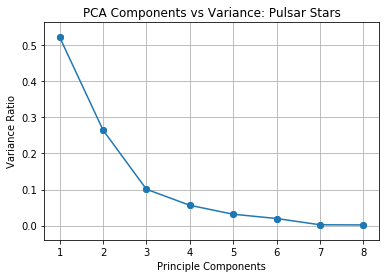

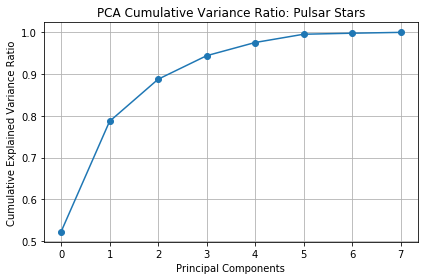

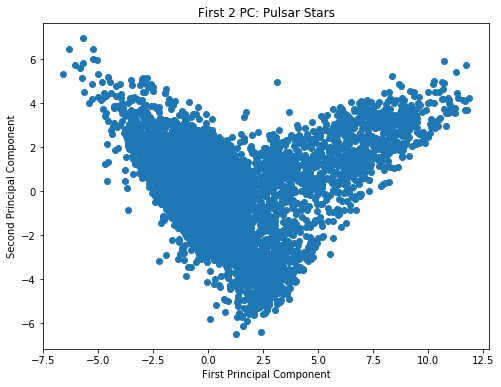

PCA reduced shape: (14318, 8)
PCA Reconstruction Error: 2.595603


/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:303: UserWarning: n_components is too large: it will be set to 8
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:303: UserWarning: n_components is too large: it will be set to 8
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:303: UserWarning: n_components is too large: it will be set to 8
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:303: UserWarning: n_components is too large: it will be set to 8
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/shi/anaconda3/envs/ml

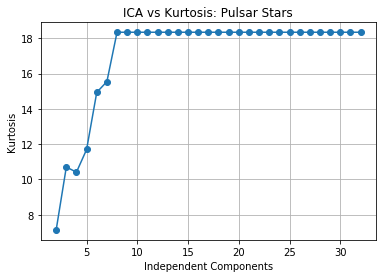

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 10).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 11).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projec

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 10).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 11).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projec

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 10).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 11).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projec

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 10).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 11).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projec

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 18).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 19).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 20).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_proje

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 10).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 11).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projec

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 23).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 24).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projec

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 10).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 11).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 12).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_proje

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 18).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 19).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 20).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_proje

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 12).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 13).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 14).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_proje

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 10).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 11).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projec

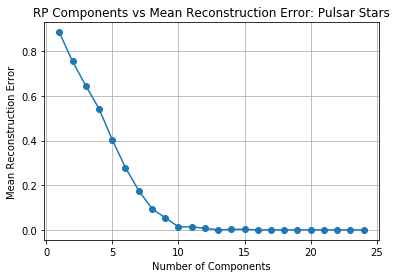

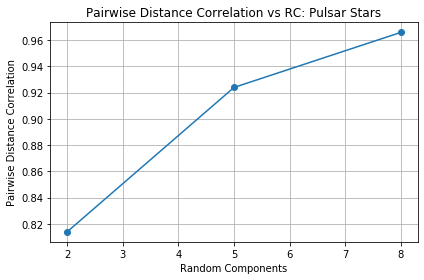

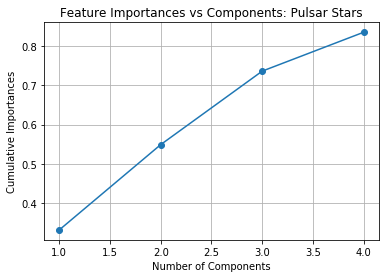

                                            Feature Importance   Cum Sum
 Excess kurtosis of the integrated profile            0.331400  0.331400
 Mean of the integrated profile                       0.217607  0.549007
 Skewness of the integrated profile                   0.187369  0.736377
 Standard deviation of the DM-SNR curve               0.099181  0.835558
[' Excess kurtosis of the integrated profile', ' Mean of the integrated profile', ' Skewness of the integrated profile', ' Standard deviation of the DM-SNR curve']
Original dataset shape is: (16382, 7)
[0, 1, 2, 3, 4, 5]


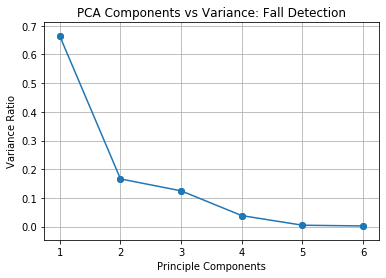

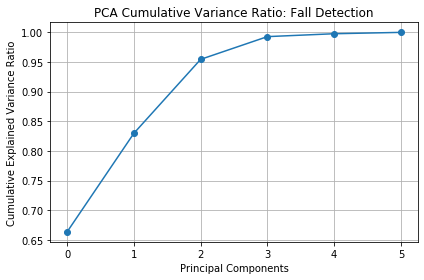

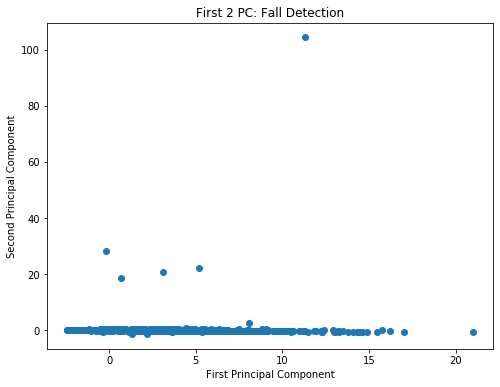

PCA reduced shape: (13105, 6)
PCA Reconstruction Error: 1.358044


/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:303: UserWarning: n_components is too large: it will be set to 6
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:303: UserWarning: n_components is too large: it will be set to 6
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:303: UserWarning: n_components is too large: it will be set to 6
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:303: UserWarning: n_components is too large: it will be set to 6
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/shi/anaconda3/envs/ml

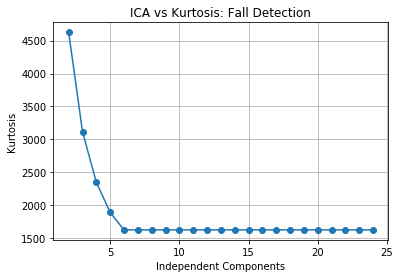

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 8).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projecti

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 17).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 18).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projec

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 8).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projecti

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 15).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 16).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 17).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_proje

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 8).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projecti

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 13).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 14).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 15).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_proje

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 8).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projecti

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 12).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 13).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 14).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_proje

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 8).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 9).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projecti

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 18).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 8).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_project

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 16).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 17).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 18).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/random_proje

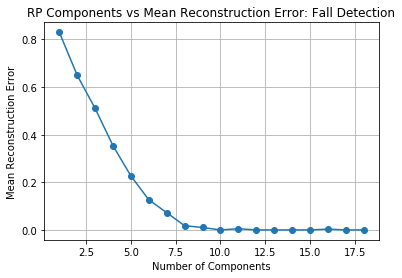

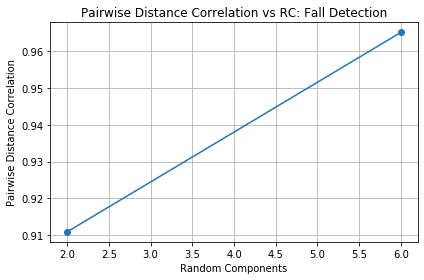

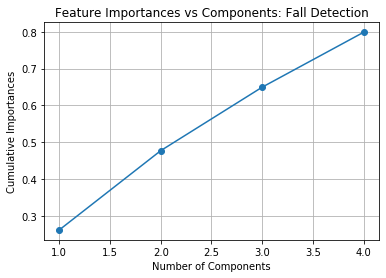

             Feature Importance   Cum Sum
EEG                    0.262296  0.262296
HR                     0.215149  0.477445
CIRCLUATION            0.172321  0.649766
SL                     0.149044  0.798810
['EEG', 'HR', 'CIRCLUATION', 'SL']


In [148]:
filename1 = "pulsar_stars.csv"
filename2 = "falldeteciton.csv"
df_pulsar = pd.read_csv("./data/" + filename1)
df_fall = pd.read_csv("./data/" + filename2)

X_pulsar, y_pulsar = load_data(filename1)
X_train, X_test, y_train, y_test = split_data(X_pulsar, y_pulsar, 0.2)
X_train, X_test = normalize_data(X_train, X_test)
run_pca(X_train, 'Pulsar Stars')
run_ica(X_train, 'Pulsar Stars')
run_rp(X_train, 'Pulsar Stars')
important, top_features = run_rf(X_train, y_train, df_pulsar, 'Pulsar Stars')
print(important)
print(top_features)

X_fall, y_fall = load_data(filename2)
X_train, X_test, y_train, y_test = split_data(X_fall, y_fall, 0.2)
X_train, X_test = normalize_data(X_train, X_test)
run_pca(X_train, 'Fall Detection')
run_ica(X_train, 'Fall Detection')
run_rp(X_train, 'Fall Detection')
important, top_features = run_rf(X_train, y_train, df_fall, 'Fall Detection')
print(important)
print(top_features)

## Part 3: Clustering with Dimensionality Reduction
Base on part 2, the number of components we chose are:
1. Pulsar Stars:
PCA: 3
ICA: 3
RP: 4
RF: 4

2. Fall Detection
PCA: 2
ICA: 3
RP: 2
RF: 4

Original dataset shape is: (17898, 9)
[0, 1]


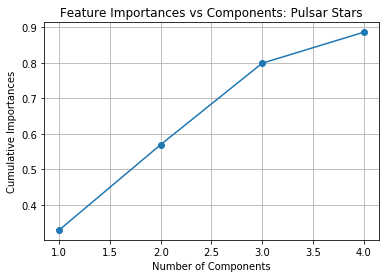

Original dataset shape is: (16382, 7)
[0, 1, 2, 3, 4, 5]


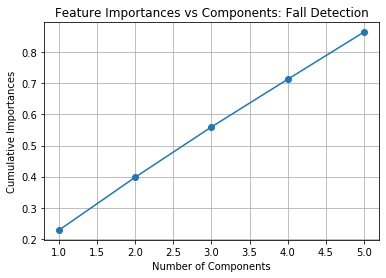

In [168]:
filename1 = "pulsar_stars.csv"
filename2 = "falldeteciton.csv"
df_pulsar = pd.read_csv("./data/" + filename1)
df_fall = pd.read_csv("./data/" + filename2)

X_pulsar, y_pulsar = load_data(filename1)
#X_train, X_test, y_train, y_test = split_data(X_pulsar, y_pulsar, 0.2)
#X_train, X_test = normalize_data(X_train, X_test)
X_pulsar = normalize(X_pulsar)
pca_pulsar = PCA(n_components=3, random_state=10).fit_transform(X_pulsar)
ica_pulsar = FastICA(n_components=3, random_state=10).fit_transform(X_pulsar)
rp_pulsar = SparseRandomProjection(n_components=4, random_state=10).fit_transform(X_pulsar)
important, top_features = run_rf(X_pulsar, y_pulsar, df_pulsar, 'Pulsar Stars')
rf_pulsar = df_pulsar[top_features]
rf_pulsar = np.array(rf_pulsar.values,dtype='float64')
#rf_pulsar = normalize(rf_pulsar)

X_fall, y_fall = load_data(filename2)
#X_train, X_test, y_train, y_test = split_data(X_fall, y_fall, 0.2)
#X_train, X_test = normalize_data(X_train, X_test)
X_fall = normalize(X_fall)
pca_fall = PCA(n_components=2, random_state=10).fit_transform(X_fall)
ica_fall = FastICA(n_components=3, random_state=10).fit_transform(X_fall)
rp_fall = SparseRandomProjection(n_components=2, random_state=10).fit_transform(X_fall)
important, top_features = run_rf(X_fall, y_fall, df_fall, 'Fall Detection')
rf_fall = df_fall[top_features]
rf_fall = np.array(rf_fall.values,dtype='float64')
#rf_fall = normalize(rf_fall)

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


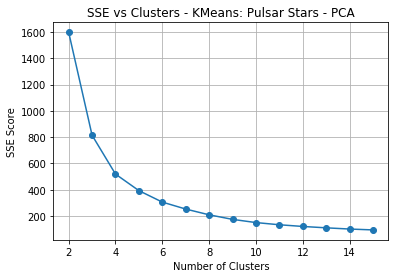

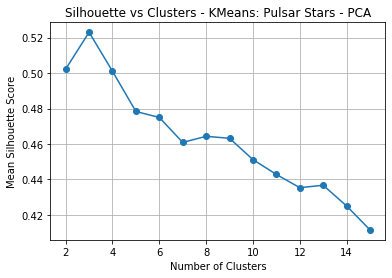

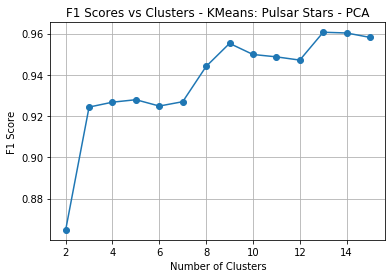

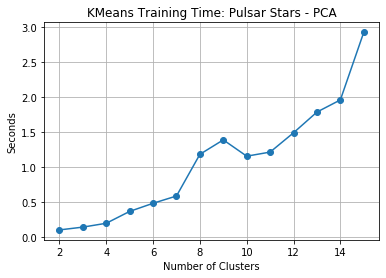

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


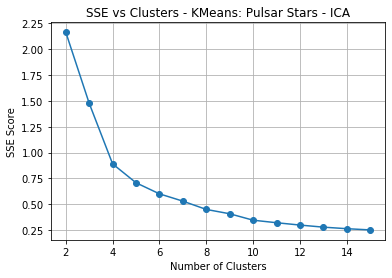

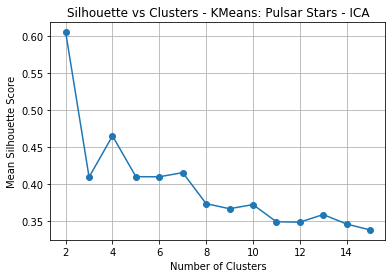

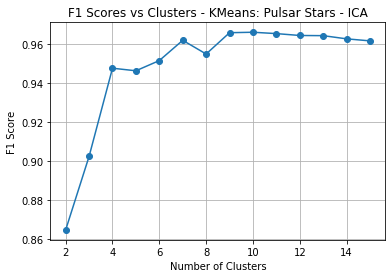

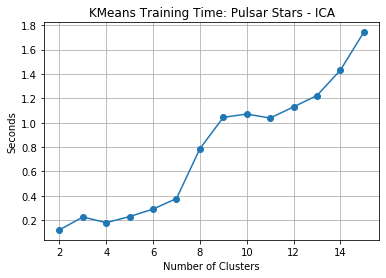

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


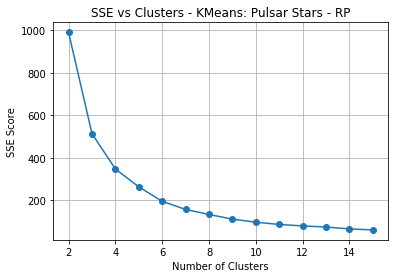

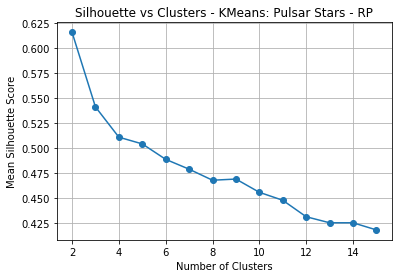

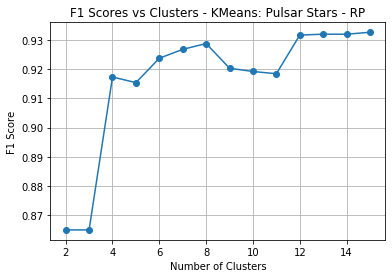

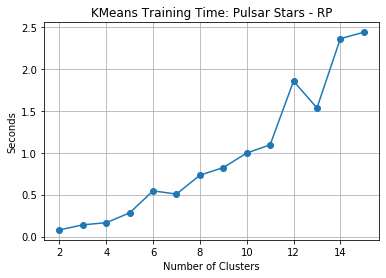

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


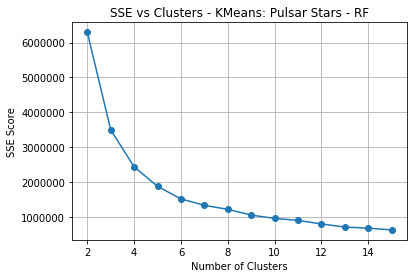

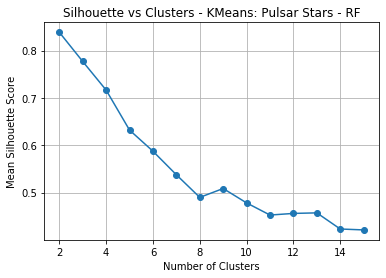

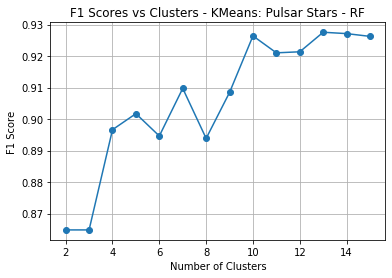

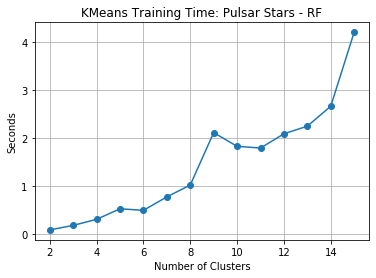

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


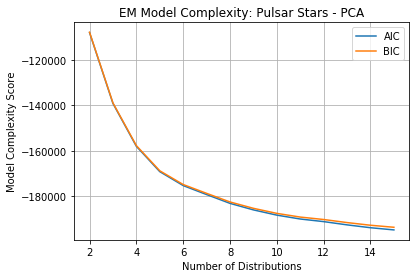

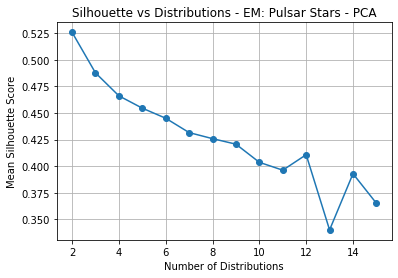

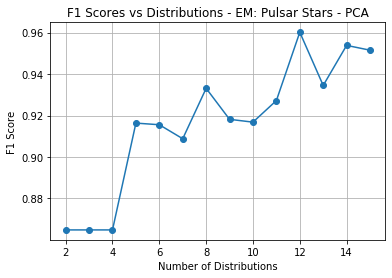

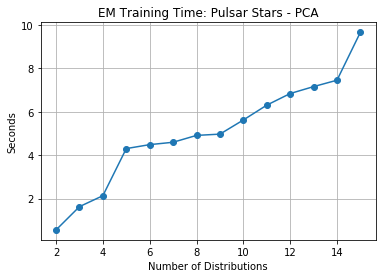

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


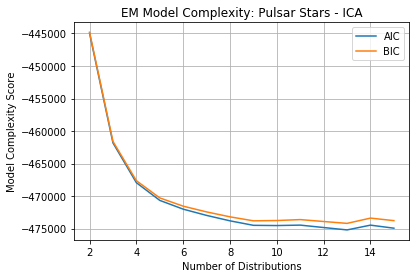

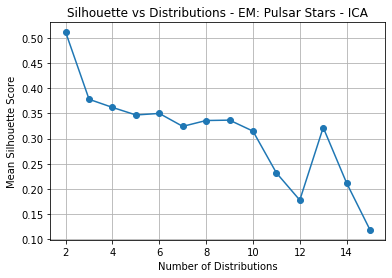

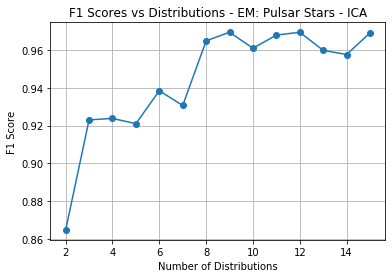

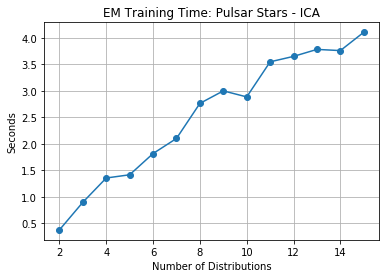

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


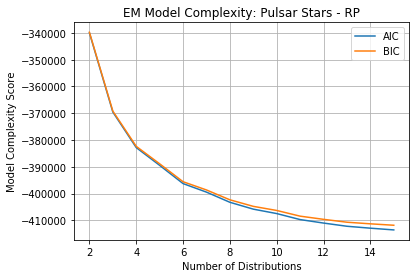

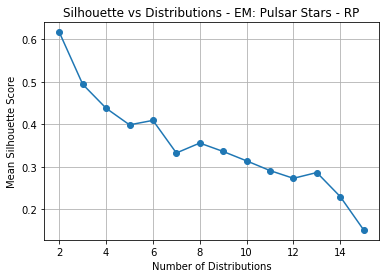

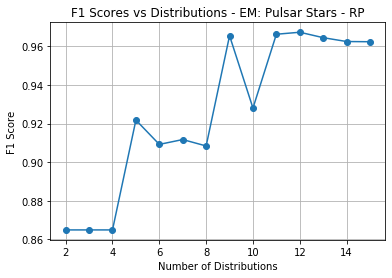

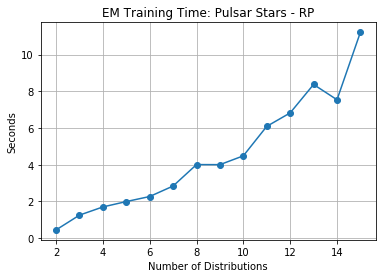

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


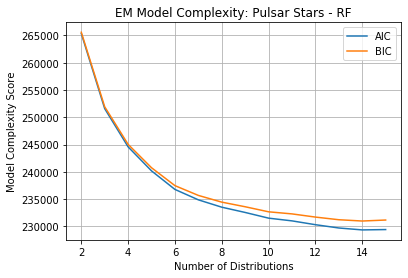

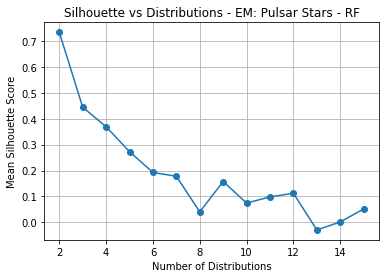

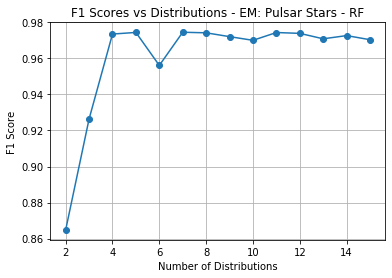

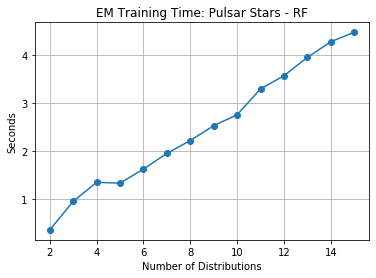

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

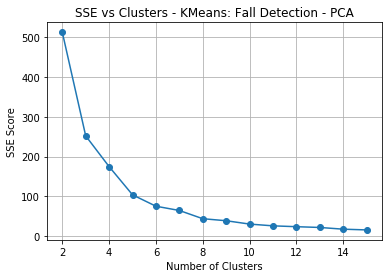

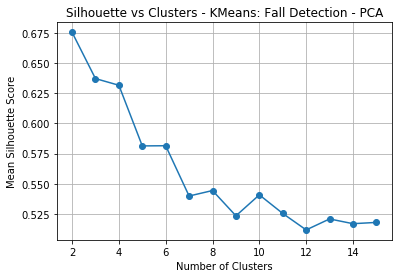

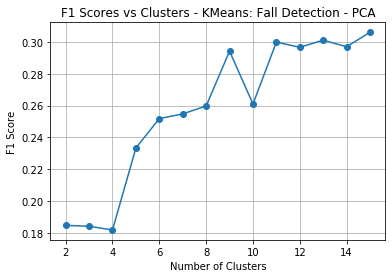

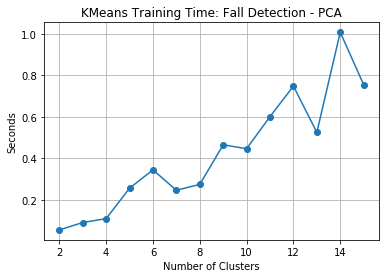

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

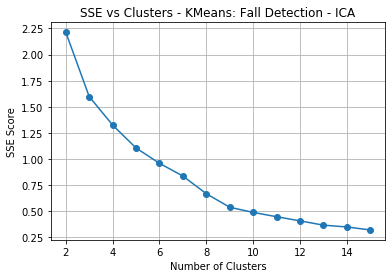

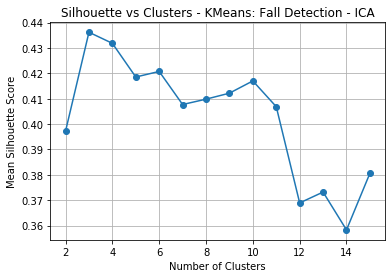

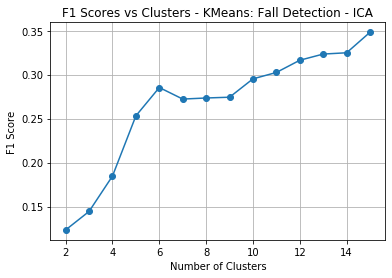

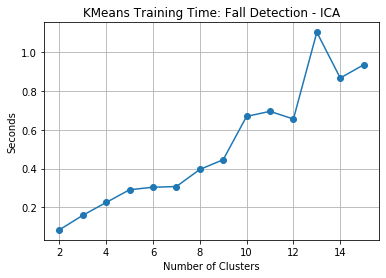

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

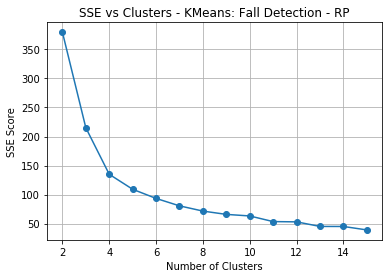

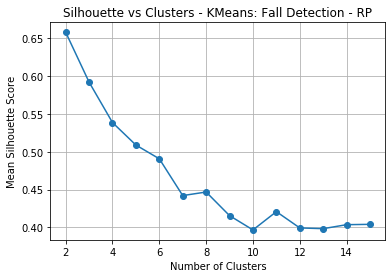

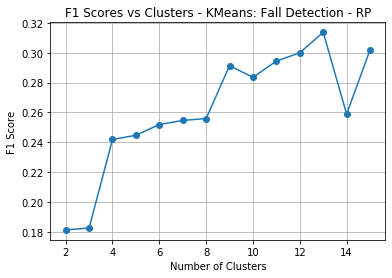

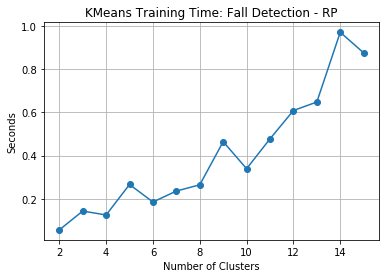

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

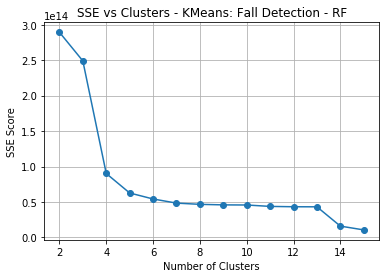

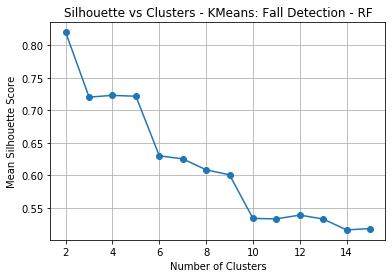

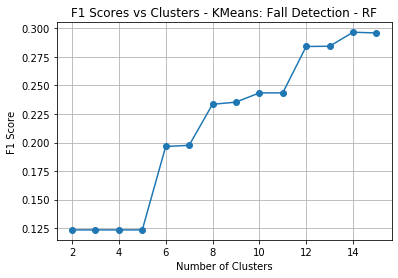

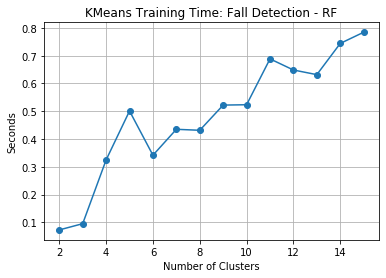

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

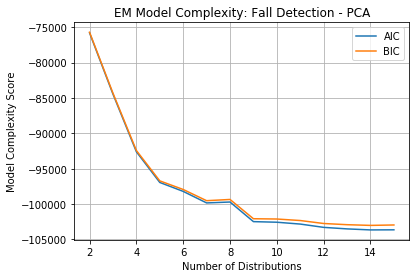

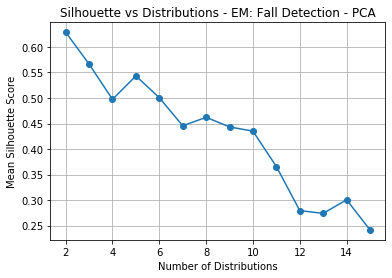

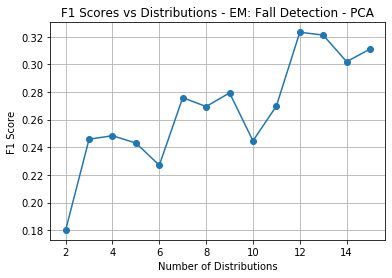

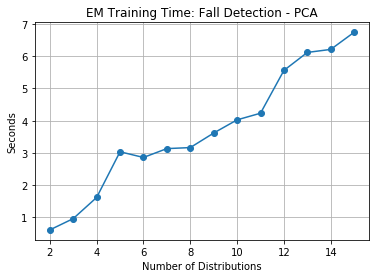

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

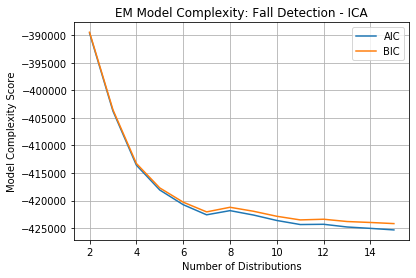

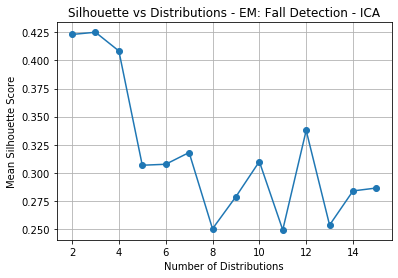

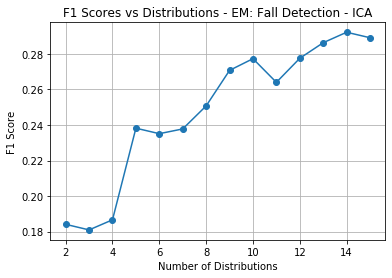

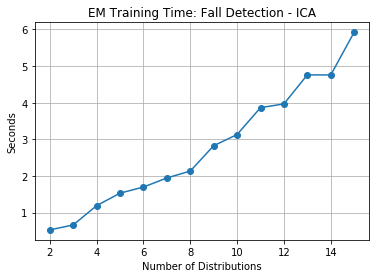

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

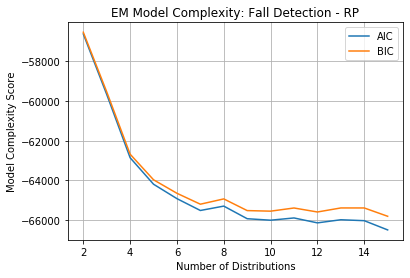

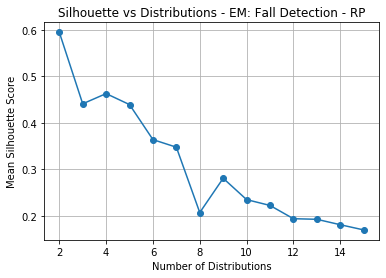

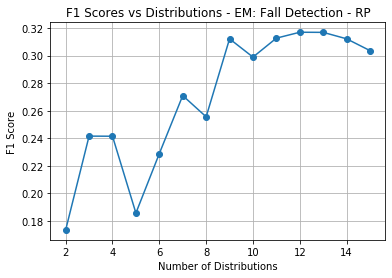

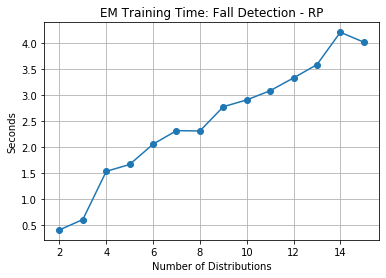

/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/shi/anaconda3/envs/ml-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

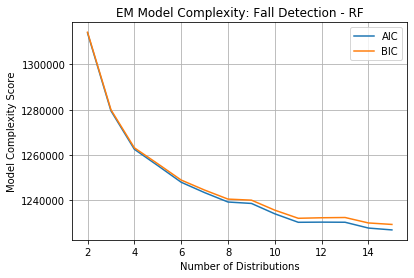

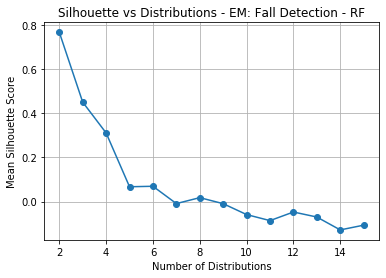

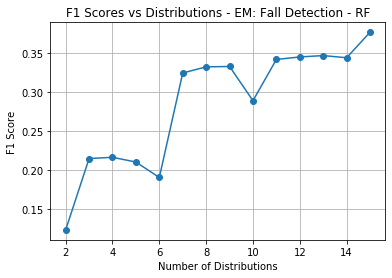

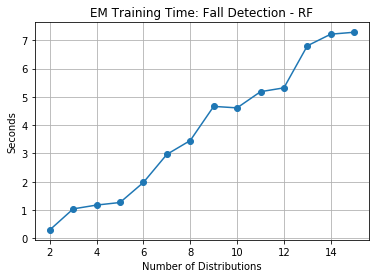

In [178]:
kmeans_cluster(pca_pulsar,y_pulsar,'Pulsar Stars - PCA')
kmeans_cluster(ica_pulsar,y_pulsar,'Pulsar Stars - ICA')
kmeans_cluster(rp_pulsar,y_pulsar,'Pulsar Stars - RP')
kmeans_cluster(rf_pulsar,y_pulsar,'Pulsar Stars - RF')
em_cluster(pca_pulsar,y_pulsar,'Pulsar Stars - PCA')
em_cluster(ica_pulsar,y_pulsar,'Pulsar Stars - ICA')
em_cluster(rp_pulsar,y_pulsar,'Pulsar Stars - RP')
em_cluster(rf_pulsar,y_pulsar,'Pulsar Stars - RF')

kmeans_cluster(pca_fall,y_fall,'Fall Detection - PCA')
kmeans_cluster(ica_fall,y_fall,'Fall Detection - ICA')
kmeans_cluster(rp_fall,y_fall,'Fall Detection - RP')
kmeans_cluster(rf_fall,y_fall,'Fall Detection - RF')
em_cluster(pca_fall,y_fall,'Fall Detection - PCA')
em_cluster(ica_fall,y_fall,'Fall Detection - ICA')
em_cluster(rp_fall,y_fall,'Fall Detection - RP')
em_cluster(rf_fall,y_fall,'Fall Detection - RF')